# Prediction of MLB Pitches with Machine Learning
This notebook applies a few machine learning algorithms to predicting the next pitch for a specific pitcher based on the previous pitch sequence.

A few notes:
- Using pitch data from throughout a pitcher's entire career is a simplistic assumption. Pitcher arsenals change over time. In this example I'm looking at Kyle Hendricks, who essentially dropped his cutter after his first couple seasons and who relied much more heavily on his 4-seam last season compared to earlier ones. It might be better to confine training data to recent seasons or more adequately take into consideration larger trends.

- As with most multiclass classification problems, evaluating which algorithm best predicts pitches is difficult. A model automatically achieves a high accuracy by simply guessing the most used pitch (some sort of fastball, generally). Ideally a model will beat this baseline accuracy and correctly identify offspeed pitches fairly often as well. 

- Since the data is sequential, I would conjecture that an LSTM-based model will perform best. However, we are dealing with very short sequences, so it's not clear that these will offer a major advantage over other methods. Whether you throw a fastball on pitch 40 depends strongly on pitch 39 and not strongly at all on pitch 10.

In [205]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import scipy as sp
from sklearn import ensemble
from sklearn.preprocessing import PolynomialFeatures
from pybaseball import *
import tensorflow.keras as keras

In [206]:
print(playerid_lookup('hendricks','kyle'))
#print(playerid_lookup('lester','jon'))

Gathering player lookup table. This may take a moment.
   name_last name_first  key_mlbam key_retro  key_bbref  key_fangraphs  \
0  hendricks       kyle         -1       NaN        NaN             -1   
1  hendricks       kyle     543294  hendk001  hendrky01          12049   

   mlb_played_first  mlb_played_last  
0               NaN              NaN  
1            2014.0           2019.0  


In [207]:
'''
Gets pitch level data for all games between given dates for chosen player.
Returns: pitcher_table_cleaned - the table
         pitch_types_valid - the different pitches the player has thrown, excluding pickoffs, nan, etc.
'''
def get_pitcher_table(start_dt, end_dt, player_id):
    pitcher_table = statcast_pitcher(start_dt, end_dt, player_id)
    pitcher_table_ordered = pitcher_table.iloc[::-1]
    
    #Drop most statcast data, fielder data, etc.
    pitcher_table_cleaned=pitcher_table_ordered.drop(columns=['release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher',
       'spin_dir', 'spin_rate_deprecated','zone',
       'break_angle_deprecated', 'break_length_deprecated', 'des', 'pitch_number',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type','release_speed',
       'hit_location', 'bb_type', 'game_year', 'pfx_x',
       'pfx_z', 'inning_topbot', 'hc_x', 'hc_y', #'plate_x', 'plate_z',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
       'woba_value', 'woba_denom', 'babip_value', 'iso_value',
       'launch_speed_angle', 'at_bat_number', 'pitch_name',
       'home_score', 'away_score', 'post_away_score',
       'post_home_score', 'post_bat_score', 'post_fld_score',
       'if_fielding_alignment', 'of_fielding_alignment',
       'events','description'])
    
    #For some reason MLB has NaN with no one on base and crazy high values with someone on base
    #so we'll change those to 0s and 1s
    pitcher_table_cleaned['on_3b']=1-pitcher_table_cleaned['on_3b'].isna().astype(int)
    pitcher_table_cleaned['on_2b']=1-pitcher_table_cleaned['on_2b'].isna().astype(int)
    pitcher_table_cleaned['on_1b']=1-pitcher_table_cleaned['on_1b'].isna().astype(int)
    
    pitcher_table_cleaned = pd.concat([pitcher_table_cleaned,pd.get_dummies(pitcher_table_cleaned['pitch_type'])],axis=1)
    
    #Get rid of pickoff and intentional walk columns if they exist
    if 'PO' in pitcher_table_cleaned['pitch_type'].unique():
        pitcher_table_cleaned = pitcher_table_cleaned.drop(columns=['PO'])
        
    if 'IN' in pitcher_table_cleaned['pitch_type'].unique():
        pitcher_table_cleaned = pitcher_table_cleaned.drop(columns=['IN'])
        
    pitch_types = pitcher_table_cleaned['pitch_type'].unique()
    pitch_types_valid = []
    for pitch in pitch_types:
        if type(pitch)==str and pitch not in ['PO','IN']:
            pitch_types_valid.append(pitch)
        
    return pitcher_table_cleaned, pitch_types_valid
    
    

In [208]:
pitcher_stats, pitch_types_valid = get_pitcher_table(start_dt='2014-04-01', end_dt='2020-07-01', player_id=543294)

Gathering Player Data
https://baseballsavant.mlb.com/statcast_search/csv?all=true&hfPT=&hfAB=&hfBBT=&hfPR=&hfZ=&stadium=&hfBBL=&hfNewZones=&hfGT=R%7CPO%7CS%7C=&hfSea=&hfSit=&player_type=pitcher&hfOuts=&opponent=&pitcher_throws=&batter_stands=&hfSA=&game_date_gt=2014-04-01&game_date_lt=2020-03-30&pitchers_lookup%5B%5D=543294&team=&position=&hfRO=&home_road=&hfFlag=&metric_1=&hfInn=&min_pitches=0&min_results=0&group_by=name&sort_col=pitches&player_event_sort=h_launch_speed&sort_order=desc&min_abs=0&type=details&
https://baseballsavant.mlb.com/statcast_search/csv?all=true&hfPT=&hfAB=&hfBBT=&hfPR=&hfZ=&stadium=&hfBBL=&hfNewZones=&hfGT=R%7CPO%7CS%7C=&hfSea=&hfSit=&player_type=pitcher&hfOuts=&opponent=&pitcher_throws=&batter_stands=&hfSA=&game_date_gt=2020-03-31&game_date_lt=2020-07-01&pitchers_lookup%5B%5D=543294&team=&position=&hfRO=&home_road=&hfFlag=&metric_1=&hfInn=&min_pitches=0&min_results=0&group_by=name&sort_col=pitches&player_event_sort=h_launch_speed&sort_order=desc&min_abs=0&type

In [209]:
pitch_types_valid

['SI', 'FC', 'CH', 'CU', 'FF']

In [210]:
pitcher_stats

,pitch_type,game_date,balls,strikes,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,bat_score,fld_score,CH,CU,FC,FF,SI
15666,SI,2014-07-10,0,0,-0.614000,4.060000,0,0,0,0,1,0,0,0,0,0,0,1
15665,SI,2014-07-10,1,0,-0.791000,3.092000,0,0,0,0,1,0,0,0,0,0,0,1
15664,SI,2014-07-10,2,0,0.639000,1.873000,0,0,0,0,1,0,0,0,0,0,0,1
15663,SI,2014-07-10,3,0,-1.160000,2.712000,0,0,0,0,1,0,0,0,0,0,0,1
15662,SI,2014-07-10,0,0,-1.194000,3.516000,0,0,1,0,1,0,0,0,0,0,0,1
15661,SI,2014-07-10,1,0,0.149000,0.990000,0,0,1,0,1,0,0,0,0,0,0,1
15660,SI,2014-07-10,2,0,-1.406000,2.906000,0,0,1,0,1,0,0,0,0,0,0,1
15659,FC,2014-07-10,3,0,0.317000,2.021000,0,0,1,0,1,0,0,0,0,1,0,0
15658,SI,2014-07-10,3,1,-1.476000,2.923000,0,0,1,0,1,0,0,0,0,0,0,1
15657,SI,2014-07-10,0,0,-0.077000,1.570000,0,1,1,0,1,0,0,0,0,0,0,1


### Let's examine the usage of each pitch in the pitcher's arsenal

In [211]:
num_SI = np.sum(pitcher_stats['SI'].values)
num_CU = np.sum(pitcher_stats['CU'].values)
num_CH = np.sum(pitcher_stats['CH'].values)
num_FF = np.sum(pitcher_stats['FF'].values)
num_FC = np.sum(pitcher_stats['FC'].values)
num_pitches = len(pitcher_stats)
pitch_ratios = np.asarray([num_SI, num_CU, num_CH, num_FF, num_FC])/float(num_pitches)

Text(0.5,1,'Pitch usage')

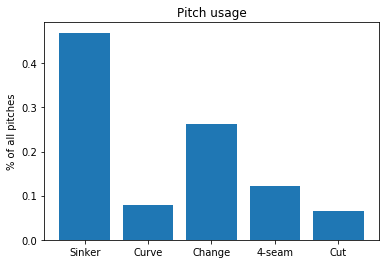

In [212]:
pitch_labels = ['Sinker', 'Curve', 'Change', '4-seam', 'Cut']
x_dist = np.arange(len(pitch_labels))
plt.bar(x_dist, pitch_ratios)
plt.xticks(x_dist, pitch_labels)
plt.ylabel('% of all pitches')
plt.title('Pitch usage')

In [213]:
pitcher_games = []

In [214]:
bad_pitches = ['PO','IN']

We still have unknown pitch types in the data. These are an exceedingly small part of the data, so we will just get rid of all games containing one.

In [215]:
lastGame = pitcher_stats.iloc[0]['game_date']
lastIndex = 0
for i in range(1,len(pitcher_stats)):
    currentGame = pitcher_stats.iloc[i]['game_date']
    if currentGame!=lastGame:
        pitches = pitcher_stats.iloc[lastIndex:i]
        if not any(elem in pitches['pitch_type'].unique() for elem in bad_pitches) and not pitches['pitch_type'].isnull().values.any():
            pitcher_games.append(pitches)
        
        lastIndex = i
        lastGame = currentGame

We will get all sequences of specified length from each game without looking at sequences spanning more than one game. Presumably the last pitch of one game doesn't have the same effect as is typical for the previous pitch in the same game.

In [216]:
seq_length = 4
pitch_seq = []
pitch_lab = []
for game in pitcher_games:
    game = game.drop(columns=['game_date'])
    for i in range(len(game)-5):
        pitch_seq.append(game.iloc[i:i+seq_length].values[:,1:])
        pitch_lab.append(game.iloc[i+seq_length].values[-5:])

In [217]:
len(pitch_lab)

12695

In [222]:
#Generate random indices for training and test data
num_training = int(0.9*len(pitch_lab))
train_ind = np.random.choice(len(pitch_seq),size=num_training,replace=False,)

#gets the complement of training indices for test set
test_ind = [x for x in np.arange(len(pitch_seq)) if x not in train_ind]

In [223]:
train_seq = np.asarray(pitch_seq).astype(np.float32)[train_ind]
test_seq = np.asarray(pitch_seq).astype(np.float32)[test_ind]

train_lab = np.asarray(pitch_lab).astype(np.float32)[train_ind]
test_lab = np.asarray(pitch_lab).astype(np.float32)[test_ind]

In [224]:
print(train_seq.shape,train_lab.shape, test_seq.shape, test_lab.shape)

(11425, 4, 16) (11425, 5) (1270, 4, 16) (1270, 5)


Code to get all metrics we'll use here below: accuracy, precision, recall, confusion matrix

In [262]:
from sklearn import metrics

def get_metrics(labels, predictions):
    
    matrix = metrics.confusion_matrix(labels, predictions)
    acc = metrics.accuracy_score(labels,predictions)
    precision =  metrics.precision_score(labels, predictions, average='macro')
    recall = metrics.recall_score(labels, predictions, average='macro')
    
    return(matrix, acc, precision, recall)

## Random Forest Classifier
We'll start off with a simple random forest classifier. Even with very unbalanced classes, this model should give a solid baseline for performance even with no preprocessing.

In [308]:
from sklearn.ensemble import RandomForestClassifier

int_train_lab = np.argmax(train_lab,axis=1)

# train model
random_forest = RandomForestClassifier(n_estimators=1000).fit(train_seq.reshape((num_training,64)), int_train_lab)

In [317]:
predictions = random_forest.predict(test_seq.reshape((len(pitch_lab)-num_training,64)))

In [310]:
predictions

array([4, 4, 4, ..., 4, 4, 4], dtype=int64)

In [318]:
matrix, acc, precision, recall = get_metrics(np.argmax(test_lab,axis=1), predictions)
print("Accuracy: ", acc)
print("Precision: ", precision)
print("Recall: ", recall)
print("Confusion matrix: \n", matrix)

Accuracy:  0.511023622047244
Precision:  0.28420757995448825
Recall:  0.2591748366013072
Confusion matrix: 
 [[102   0   0  10 208]
 [ 21   0   0   1  81]
 [ 15   0   0   0  67]
 [ 36   0   0  17 100]
 [ 74   0   0   8 530]]


C:\Users\Jimmy\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


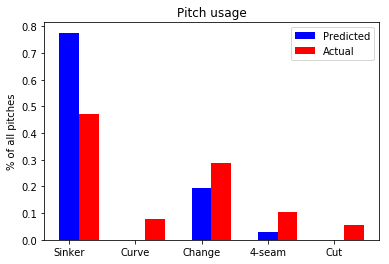

In [319]:

pred_CH = np.sum(predictions==0)
pred_CU = np.sum(predictions==1)
pred_FC = np.sum(predictions==2)
pred_FF = np.sum(predictions==3)
pred_SI = np.sum(predictions==4)

pred_pitches = len(predictions)

pred_ratios = np.asarray([pred_SI, pred_CU, pred_CH, pred_FF, pred_FC])/float(pred_pitches)

lab_CH = np.sum(labels==0)
lab_CU = np.sum(labels==1)
lab_FC = np.sum(labels==2)
lab_FF = np.sum(labels==3)
lab_SI = np.sum(labels==4)

lab_pitches = len(labels)

lab_ratios = np.asarray([lab_SI, lab_CU, lab_CH, lab_FF, lab_FC])/float(lab_pitches)

bar_width=0.3
pitch_labels = ['Sinker', 'Curve', 'Change', '4-seam', 'Cut']
x_dist = np.arange(len(pitch_labels))
plt.bar(x_dist, pred_ratios,bar_width, color='b',label = 'Predicted')
plt.bar(x_dist+bar_width, lab_ratios, bar_width, color = 'r', label = 'Actual')
plt.xticks(x_dist, pitch_labels)
plt.ylabel('% of all pitches')
plt.title('Pitch usage')
plt.legend()

We can see that the model over-predicts sinkers. This is unsurprising, because we have unbalanced classes and the sinker is the most likely pitch.

## LSTM network

In [327]:
def get_pitch_predictor_network():
    inputs = keras.Input(shape=(4,16))
    #LSTM1 = keras.layers.LSTM(5,return_sequences=True)(inputs)
    LSTM2 = keras.layers.LSTM(20)(inputs)
    dropout = keras.layers.Dropout(0.1)
    outputs = keras.layers.Dense(5,activation=keras.activations.softmax)(LSTM2)
    return keras.Model(inputs=inputs, outputs=outputs)

In [328]:
model = get_pitch_predictor_network()
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 4, 16)]           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 20)                2960      
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 105       
Total params: 3,065
Trainable params: 3,065
Non-trainable params: 0
_________________________________________________________________


In [331]:
model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])

In [332]:
#We'll reserve 10% of the data for validation to avoid overfitting
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', patience = 5)
model.fit(train_seq,train_lab,batch_size=128, epochs=1000, validation_split=0.1, callbacks=[early_stopping])

Train on 10282 samples, validate on 1143 samples
Epoch 1/1000
10282/10282 [==============================] - 4s 404us/sample - loss: 1.2754 - accuracy: 0.4948 - val_loss: 1.2608 - val_accuracy: 0.4996
Epoch 2/1000
10282/10282 [==============================] - 0s 37us/sample - loss: 1.2632 - accuracy: 0.5001 - val_loss: 1.2538 - val_accuracy: 0.5057
Epoch 3/1000
10282/10282 [==============================] - 0s 37us/sample - loss: 1.2538 - accuracy: 0.5030 - val_loss: 1.2440 - val_accuracy: 0.5109
Epoch 4/1000
10282/10282 [==============================] - 0s 41us/sample - loss: 1.2453 - accuracy: 0.5034 - val_loss: 1.2432 - val_accuracy: 0.5057
Epoch 5/1000
10282/10282 [==============================] - 0s 38us/sample - loss: 1.2389 - accuracy: 0.5061 - val_loss: 1.2375 - val_accuracy: 0.5118
Epoch 6/1000
10282/10282 [==============================] - 0s 39us/sample - loss: 1.2342 - accuracy: 0.5068 - val_loss: 1.2335 - val_accuracy: 0.5083
Epoch 7/1000
10282/10282 [==================

In [333]:
predictions = model.predict(test_seq)

In [334]:
matrix, acc, precision, recall = get_metrics(np.argmax(test_lab,axis=1), np.argmax(predictions,axis=1))
print("Accuracy: ", acc)
print("Precision: ", precision)
print("Recall: ", recall)
print("Confusion matrix: \n", matrix)

Accuracy:  0.5055118110236221
Precision:  0.3401852115673704
Recall:  0.2735793280726925
Confusion matrix: 
 [[117   0   3  16 184]
 [ 21   0   0   4  78]
 [ 17   0   3   0  62]
 [ 45   0   0  23  85]
 [ 93   0   2  18 499]]


C:\Users\Jimmy\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


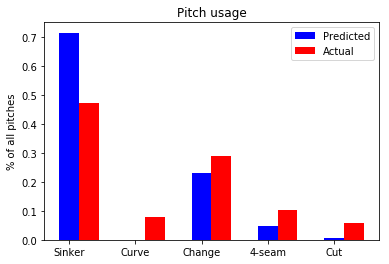

In [335]:
actual_preds = np.argmax(np.array(predictions),axis=1)
pred_CH = np.sum(actual_preds==0)
pred_CU = np.sum(actual_preds==1)
pred_FC = np.sum(actual_preds==2)
pred_FF = np.sum(actual_preds==3)
pred_SI = np.sum(actual_preds==4)

pred_pitches = len(actual_preds)

pred_ratios = np.asarray([pred_SI, pred_CU, pred_CH, pred_FF, pred_FC])/float(pred_pitches)

lab_CH = np.sum(labels==0)
lab_CU = np.sum(labels==1)
lab_FC = np.sum(labels==2)
lab_FF = np.sum(labels==3)
lab_SI = np.sum(labels==4)

lab_pitches = len(labels)

lab_ratios = np.asarray([lab_SI, lab_CU, lab_CH, lab_FF, lab_FC])/float(lab_pitches)

bar_width=0.3
pitch_labels = ['Sinker', 'Curve', 'Change', '4-seam', 'Cut']
x_dist = np.arange(len(pitch_labels))
plt.bar(x_dist, pred_ratios,bar_width, color='b',label = 'Predicted')
plt.bar(x_dist+bar_width, lab_ratios, bar_width, color = 'r', label = 'Actual')
plt.xticks(x_dist, pitch_labels)
plt.ylabel('% of all pitches')
plt.title('Pitch usage')
plt.legend()

The LSTM model outperforms the random forest by precision and recall and is slightly worse by accuracy. It predicts more off-speed pitches than the RF model as well, those still far fewer than the ground truth.

## Accounting for unbalanced classes
In order to account for unbalanced classes and hopefully enforce a similar pitch mix to the ground truth, we will give classes weights inversely proportional to their frequency.

In [342]:
int_lab = np.argmax(train_lab,axis=1)
train_CH = np.sum(int_lab==0)
train_CU = np.sum(int_lab==1)
train_FC = np.sum(int_lab==2)
train_FF = np.sum(int_lab==3)
train_SI = np.sum(int_lab==4)

class_weights = float(train_SI)/np.asarray([train_CH, train_CU, train_FC, train_FF, train_SI])
weight_dict = {}
for i in range(len(class_weights)):
    weight_dict[i]=class_weights[i]
print(weight_dict)

{0: 1.7540348612007748, 1: 5.738120380147835, 2: 7.87536231884058, 3: 4.326433121019108, 4: 1.0}


### Random Forest with Class Weights

In [343]:
random_forest = RandomForestClassifier(n_estimators=1000,class_weight=weight_dict).fit(
    train_seq.reshape((num_training,64)), int_train_lab)

In [344]:
predictions = random_forest.predict(test_seq.reshape((len(pitch_lab)-num_training,64)))

In [345]:
matrix, acc, precision, recall = get_metrics(np.argmax(test_lab,axis=1), predictions)
print("Accuracy: ", acc)
print("Precision: ", precision)
print("Recall: ", recall)
print("Confusion matrix: \n", matrix)

Accuracy:  0.5055118110236221
Precision:  0.28510840649108804
Recall:  0.2488357843137255
Confusion matrix: 
 [[ 75   0   0  11 234]
 [ 10   0   0   1  92]
 [  9   0   0   0  73]
 [ 29   0   0  17 107]
 [ 56   0   0   6 550]]


C:\Users\Jimmy\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


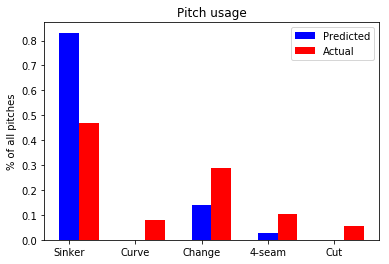

In [346]:
pred_CH = np.sum(predictions==0)
pred_CU = np.sum(predictions==1)
pred_FC = np.sum(predictions==2)
pred_FF = np.sum(predictions==3)
pred_SI = np.sum(predictions==4)

pred_pitches = len(predictions)

pred_ratios = np.asarray([pred_SI, pred_CU, pred_CH, pred_FF, pred_FC])/float(pred_pitches)

lab_CH = np.sum(labels==0)
lab_CU = np.sum(labels==1)
lab_FC = np.sum(labels==2)
lab_FF = np.sum(labels==3)
lab_SI = np.sum(labels==4)

lab_pitches = len(labels)

lab_ratios = np.asarray([lab_SI, lab_CU, lab_CH, lab_FF, lab_FC])/float(lab_pitches)

bar_width=0.3
pitch_labels = ['Sinker', 'Curve', 'Change', '4-seam', 'Cut']
x_dist = np.arange(len(pitch_labels))
plt.bar(x_dist, pred_ratios,bar_width, color='b',label = 'Predicted')
plt.bar(x_dist+bar_width, lab_ratios, bar_width, color = 'r', label = 'Actual')
plt.xticks(x_dist, pitch_labels)
plt.ylabel('% of all pitches')
plt.title('Pitch usage')
plt.legend()

Performance is disappointing. This actually seems worse than using no class weights.

## LSTM with Class Weights

In [347]:
model = get_pitch_predictor_network()
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 4, 16)]           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 20)                2960      
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 105       
Total params: 3,065
Trainable params: 3,065
Non-trainable params: 0
_________________________________________________________________


In [348]:
model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])

In [349]:
#We'll reserve 10% of the data for validation to avoid overfitting
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', patience = 5)
model.fit(train_seq,train_lab,batch_size=128, epochs=1000,
          class_weight=weight_dict,validation_split=0.1, callbacks=[early_stopping])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 10282 samples, validate on 1143 samples
Epoch 1/1000
10282/10282 [==============================] - 4s 351us/sample - loss: 3.8185 - accuracy: 0.1906 - val_loss: 3.6862 - val_accuracy: 0.1977
Epoch 2/1000
10282/10282 [==============================] - 0s 49us/sample - loss: 3.7532 - accuracy: 0.2241 - val_loss: 3.6498 - val_accuracy: 0.2362
Epoch 3/1000
10282/10282 [==============================] - 1s 50us/sample - loss: 3.7022 - accuracy: 0.2504 - val_loss: 3.5987 - val_accuracy: 0.2668
Epoch 4/1000
10282/10282 [==============================] - 1s 50us/sample - loss: 3.6517 - accuracy: 0.2784 - val_loss: 3.5675 - val_accuracy: 0.2835
Epoch 5/1000
10282/10282 [==============================] - 0s 48us/sample - loss: 3.6032 - accuracy: 0.2991 - val_loss: 3.5369 - val_accuracy: 0.2765
Epoch 6/1000
10282/10282 [==============================] - 1s 56us/sample - loss: 3.5599 - accuracy: 0.3118 - val_loss: 3.5099 - val_accuracy: 0

In [350]:
predictions = model.predict(test_seq)

In [351]:
matrix, acc, precision, recall = get_metrics(np.argmax(test_lab,axis=1), np.argmax(predictions,axis=1))
print("Accuracy: ", acc)
print("Precision: ", precision)
print("Recall: ", recall)
print("Confusion matrix: \n", matrix)

Accuracy:  0.34330708661417325
Precision:  0.30339836237216816
Recall:  0.34590815604401043
Confusion matrix: 
 [[ 69  57  56  68  70]
 [ 17  15  22  18  31]
 [ 11  11  44   2  14]
 [ 23  25  10  67  28]
 [ 67  81 136  87 241]]


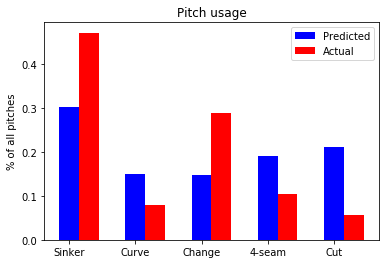

In [353]:
actual_preds = np.argmax(np.array(predictions),axis=1)
pred_CH = np.sum(actual_preds==0)
pred_CU = np.sum(actual_preds==1)
pred_FC = np.sum(actual_preds==2)
pred_FF = np.sum(actual_preds==3)
pred_SI = np.sum(actual_preds==4)

pred_pitches = len(actual_preds)

pred_ratios = np.asarray([pred_SI, pred_CU, pred_CH, pred_FF, pred_FC])/float(pred_pitches)

lab_CH = np.sum(labels==0)
lab_CU = np.sum(labels==1)
lab_FC = np.sum(labels==2)
lab_FF = np.sum(labels==3)
lab_SI = np.sum(labels==4)

lab_pitches = len(labels)

lab_ratios = np.asarray([lab_SI, lab_CU, lab_CH, lab_FF, lab_FC])/float(lab_pitches)

bar_width=0.3
pitch_labels = ['Sinker', 'Curve', 'Change', '4-seam', 'Cut']
x_dist = np.arange(len(pitch_labels))
plt.bar(x_dist, pred_ratios,bar_width, color='b',label = 'Predicted')
plt.bar(x_dist+bar_width, lab_ratios, bar_width, color = 'r', label = 'Actual')
plt.xticks(x_dist, pitch_labels)
plt.ylabel('% of all pitches')
plt.title('Pitch usage')
plt.legend()

The accuracy and precision of the model have decreased, but the recall is significantly improved. The model now over-predicts less used pitches. For some pitchers, maybe this would be helpful if e.g. you especially want to know when an offspeed pitch is coming (though here accuracy is low for the lesser used pitches). Class weights could be tweaked as necessary.

## Final thoughts and future directions:

While the accuracy of both the RF and LSTM models is not exceptional, it is better than simply sitting on the most-used pitch every time. Both models demonstrate some proficiency at predicting changeups correctly as well.

Results might differ significantly depending on the pitcher's arsenal and time frame used. The performance of the classifier against a particular pitcher might be used as a proxy of the pitcher's predictably. Those that perform poorly could be better served by mixing up their pitches more randomly.

Next I'll take a look at the regression counterpart to this problem - predicting the location of the next pitch based on the last several pitches.